<a href="https://colab.research.google.com/github/spykeshivam/EmotionFace_CVAE/blob/master/emotionvae_best(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
from tqdm import tqdm
import torchvision.models as models
import copy
import zipfile


In [ ]:
%ls

sample_data/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/


/content/drive/MyDrive


In [ ]:
import zipfile
import os
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms
from PIL import Image

# Extract both datasets
zip_paths = [
    "/content/drive/MyDrive/data/data_for_zip.zip",
    "/content/drive/MyDrive/data/affectNet.zip"
]
extract_paths = [
    "/content/dataset1",
    "/content/dataset2"
]

In [ ]:
for zip_path, extract_path in zip(zip_paths, extract_paths):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print(f"Dataset extracted to: {extract_path}")

Dataset extracted to: /content/dataset1
Dataset extracted to: /content/dataset2


In [ ]:
import os
print("Top-level files and folders:")
print(os.listdir('/content/dataset2/'))
print(os.listdir('/content/dataset1/'))

Top-level files and folders:
['YOLO_format']
['data_for_zip']


In [ ]:
%cd /content/

/content


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Set random seed for reproducibility
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define paths
data_dir = "dataset2/YOLO_format/"
train_dir = os.path.join(data_dir, "train")
valid_dir = os.path.join(data_dir, "valid")
test_dir = os.path.join(data_dir, "test")

# Define constants
BATCH_SIZE = 64
EPOCHS = 30
LATENT_DIM = 128
FACENET_EMBEDDING_DIM = 512
LEARNING_RATE = 1e-4
NUM_CONDITIONS = 2  # Only happy and angry

# Emotion mapping - we're only using Anger (0) and Happy (4)
emotion_class_map = {
    0: 'Anger',  # Original class ID 0
    1: 'Happy'   # Original class ID 4 mapped to 1 for our binary classification
}

# Which original classes to keep (Anger=0, Happy=4)
keep_classes = [0, 4]

# Custom dataset2 class for loading the face images with emotion labels
class FaceEmotionDataset2(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Get all image files
        images_dir = os.path.join(root_dir, "images")
        labels_dir = os.path.join(root_dir, "labels")
        count=0
        for img_name in os.listdir(images_dir):
            if img_name.endswith(('.jpg', '.jpeg', '.png')):
                # Get corresponding label file
                base_name = os.path.splitext(img_name)[0]
                label_file = os.path.join(labels_dir, f"{base_name}.txt")

                # Only include images that have corresponding label files
                if os.path.exists(label_file):
                    # Read label to check if it's Happy or Angry
                    with open(label_file, 'r') as f:
                        label_line = f.readline().strip().split()
                        original_class_id = int(label_line[0])

                        # Only keep Happy (4) and Angry (0) classes
                        if original_class_id in keep_classes:
                            count+=1
                            # Map the original class IDs to our binary labels:
                            # 0 (Anger) stays as 0
                            # 4 (Happy) becomes 1
                            new_class_id = 0 if original_class_id == 0 else 1

                            self.image_paths.append(os.path.join(images_dir, img_name))
                            self.labels.append(new_class_id)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
      img_path = self.image_paths[idx]
      class_id = self.labels[idx]

      # Read image (in original size)
      image = Image.open(img_path).convert('L')

      # Only print image size for the first few samples to avoid flooding the output

      # Convert label to one-hot encoding
      label_one_hot = torch.zeros(NUM_CONDITIONS)
      label_one_hot[class_id] = 1.0

      if self.transform:
          image = self.transform(image)

      return image, label_one_hot, class_id
    # Return image, one-hot encoded label, and class index

# FaceNet requires input size of 160x160
facenet_transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize
])

# Create dataset2s and dataloaders
train_dataset2 = FaceEmotionDataset2(train_dir, transform=facenet_transform)
valid_dataset2 = FaceEmotionDataset2(valid_dir, transform=facenet_transform)
test_dataset2 = FaceEmotionDataset2(test_dir, transform=facenet_transform)

# Print dataset2 info
print(f"Training images: {len(train_dataset2)}")
print(f"Training images: {len(valid_dataset2)}")
print(f"Testing images: {len(test_dataset2)}")

Using device: cuda
Training images: 4493
Training images: 1503
Testing images: 782


In [ ]:


# Set random seed for reproducibility
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define paths
data_dir = "dataset1/data_for_zip/"
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")

# Define constants
BATCH_SIZE = 64
EPOCHS = 30
LATENT_DIM = 128
FACENET_EMBEDDING_DIM = 512
LEARNING_RATE = 1e-4
NUM_CONDITIONS = 2  # happy and angry

# Custom dataset1 class for loading the black and white face images
class FaceEmotionDataset1(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Get labels from directory structure
        # 0 for angry, 1 for happy
        for label_id, emotion in enumerate(["angry", "happy"]):
            emotion_dir = os.path.join(root_dir, emotion)
            if os.path.exists(emotion_dir):
                for img_name in os.listdir(emotion_dir):
                    if img_name.endswith(('.jpg', '.jpeg', '.png')):
                        self.image_paths.append(os.path.join(emotion_dir, img_name))
                        self.labels.append(label_id)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('L')  # Convert to grayscale
        label = self.labels[idx]

        # Convert label to one-hot encoding
        label_one_hot = torch.zeros(NUM_CONDITIONS)
        label_one_hot[label] = 1.0

        if self.transform:
            image = self.transform(image)

        return image, label_one_hot, label  # Return image, one-hot encoded label, and class index

# FaceNet requires input size of 160x160
facenet_transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize grayscale images
])

# Create dataset1s and dataloaders
train_dataset1 = FaceEmotionDataset1(train_dir, transform=facenet_transform)
test_dataset1 = FaceEmotionDataset1(test_dir, transform=facenet_transform)

train_dataset1_shuffled = copy.deepcopy(train_dataset1)
indices = torch.randperm(len(train_dataset1)).tolist()
train_dataset1_shuffled.image_paths = [train_dataset1.image_paths[i] for i in indices]
train_dataset1_shuffled.labels = [train_dataset1.labels[i] for i in indices]

# Print dataset info
print(f"Training images: {len(train_dataset1)}")
print(f"Shuffled training images: {len(train_dataset1_shuffled)}")
print(f"Testing images: {len(test_dataset1)}")

# Print dataset1 info
print(f"Training images: {len(train_dataset1)}")
print(f"Testing images: {len(test_dataset1)}")



Using device: cuda
Training images: 12794
Shuffled training images: 12794
Testing images: 2843
Training images: 12794
Testing images: 2843


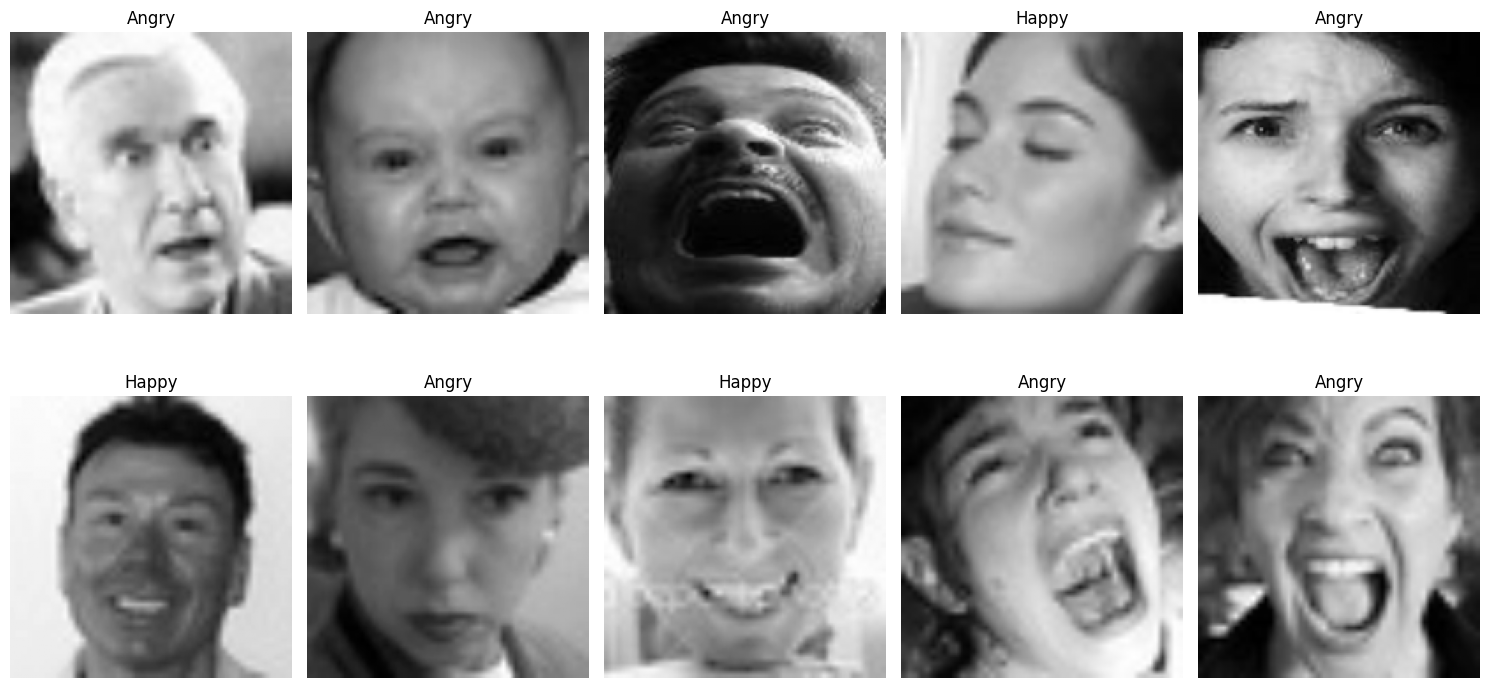

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random

# Set the figure size
plt.figure(figsize=(15, 8))

# Choose 10 random indices
random_indices = random.sample(range(len(train_dataset1)), 10)

# Map numeric labels to emotion names
emotion_map = {0: "Angry", 1: "Happy"}

# Plot each image
for i, idx in enumerate(random_indices):
    image, _, label = train_dataset1[idx]  # Get image and class index
    # Convert from tensor to numpy array
    # Denormalize: (img * std) + mean
    image_np = (image.numpy()[0] * 0.5 + 0.5)  # Convert from [-1,1] to [0,1]

    # Create subplot
    plt.subplot(2, 5, i+1)
    plt.imshow(image_np, cmap='gray')
    plt.title(f"{emotion_map[label]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
from torch.utils.data import ConcatDataset

# Merge training datasets (train_dataset1, train_dataset2, valid_dataset2)
train_dataset = ConcatDataset([train_dataset1, train_dataset2, valid_dataset2])

# Merge test datasets (test_dataset1, test_dataset2)
test_dataset = ConcatDataset([test_dataset1, test_dataset2])

# Create data loaders for the merged datasets
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Print information about the merged datasets
print(f"Combined training dataset size: {len(train_dataset)} images")
print(f"Combined test dataset size: {len(test_dataset)} images")

# Calculate class distribution in the merged training dataset
class_counts_train = [0, 0]  # For Angry (0) and Happy (1)

# Count classes in train_dataset1
for _, _, label in train_dataset1:
    class_counts_train[label] += 1

# Count classes in train_dataset2
for _, _, label in train_dataset2:
    class_counts_train[label] += 1

# Count classes in valid_dataset2
for _, _, label in valid_dataset2:
    class_counts_train[label] += 1

# Print class distribution for the combined training dataset
print("\nClass distribution in combined training dataset:")
print(f"Angry: {class_counts_train[0]} images ({class_counts_train[0]/len(train_dataset)*100:.2f}%)")
print(f"Happy: {class_counts_train[1]} images ({class_counts_train[1]/len(train_dataset)*100:.2f}%)")

Combined training dataset size: 18790 images
Combined test dataset size: 3625 images

Class distribution in combined training dataset:
Angry: 8630 images (45.93%)
Happy: 10160 images (54.07%)


Visualizing samples from a batch...


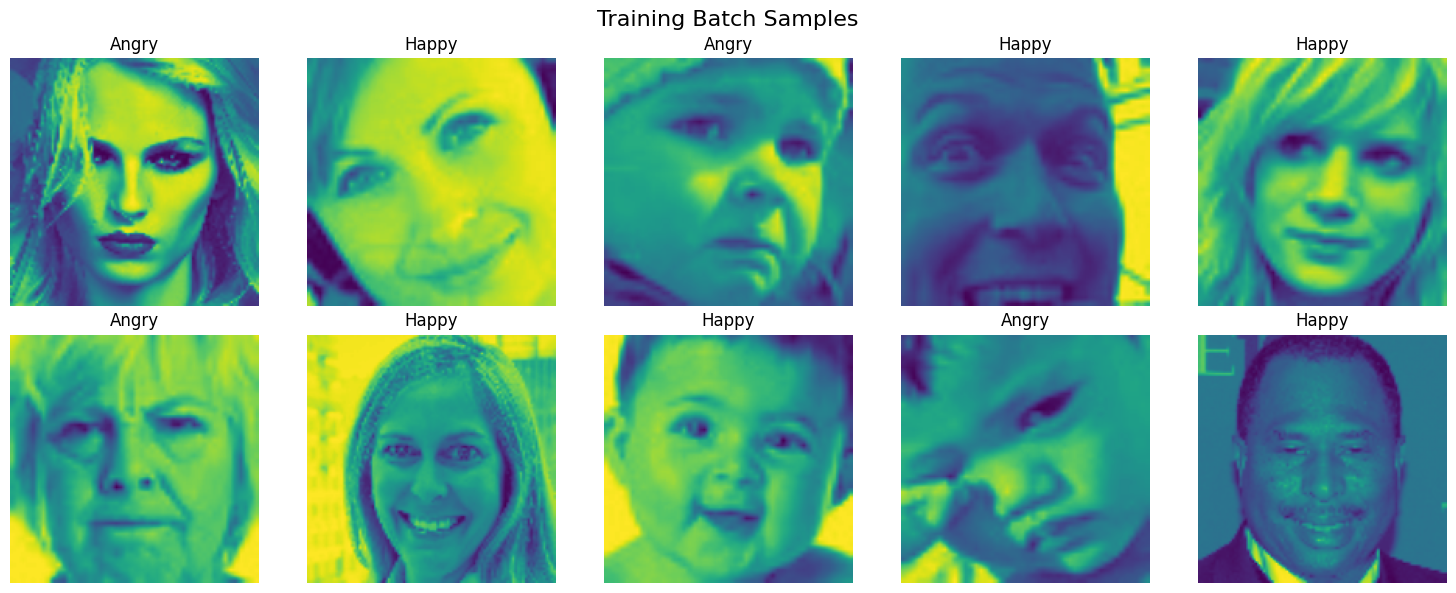

In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from torch.utils.data import DataLoader
import random

def visualize_batch(dataloader, title="Batch Samples"):
    """
    Visualize a batch of samples from the dataloader
    """
    # Get a batch
    images, conditions, labels = next(iter(dataloader))

    # Select 10 images (or fewer if batch size is smaller)
    num_samples = min(10, images.size(0))

    # Set up the figure
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()

    for i in range(num_samples):
        # Convert tensor to numpy for plotting
        img_np = images[i].numpy().squeeze()

        # Denormalize
        img_np = img_np * 0.5 + 0.5

        # Get emotion label
        emotion = "Happy" if labels[i] == 1 else "Angry"

        # Plot
        axes[i].imshow(img_np)
        axes[i].set_title(f"{emotion}")
        axes[i].axis('off')

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

# Visualize a batch (alternative approach)
print("Visualizing samples from a batch...")
visualize_batch(train_loader, title="Training Batch Samples")

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Constants - these should match your original implementation
LATENT_DIM = 128  # Assuming this value from your code
NUM_CONDITIONS = 10  # Assuming this value from your code
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LEARNING_RATE = 1e-4  # Assuming this value from your code

# First, let's create a FiLM layer that will modulate features based on conditions
class FiLMLayer(nn.Module):
    def __init__(self, num_features, condition_dim):
        super(FiLMLayer, self).__init__()
        # Project condition to generate gamma (scale) and beta (bias) for feature modulation
        self.condition_project = nn.Linear(condition_dim, num_features * 2)

    def forward(self, x, condition):
        # x shape: [batch_size, num_features, height, width]
        batch_size, num_features = x.size(0), x.size(1)

        # Generate gamma and beta parameters from condition
        condition_params = self.condition_project(condition)  # [batch_size, num_features*2]

        # Split into gamma and beta
        gamma, beta = torch.split(condition_params, num_features, dim=1)

        # Reshape for broadcasting
        gamma = gamma.view(batch_size, num_features, 1, 1)
        beta = beta.view(batch_size, num_features, 1, 1)

        # Apply feature-wise transformation: gamma * x + beta
        return gamma * x + beta

# Define a Residual Block for the Encoder
class EncoderResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, condition_dim, stride=1):
        super(EncoderResidualBlock, self).__init__()

        # First convolution path
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.film1 = FiLMLayer(out_channels, condition_dim)

        # Second convolution path
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.film2 = FiLMLayer(out_channels, condition_dim)

        # Skip connection with 1x1 conv if dimensions change
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x, condition):
        # Main path
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.film1(out, condition)
        out = F.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.film2(out, condition)

        # Skip connection
        residual = self.shortcut(x)

        # Combine main path with skip connection
        out += residual
        out = F.relu(out)

        return out

# Define a Residual Block for the Decoder
class DecoderResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, condition_dim, upsample=False):
        super(DecoderResidualBlock, self).__init__()

        # First convolution path
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.film1 = FiLMLayer(out_channels, condition_dim)

        # Second convolution path
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.film2 = FiLMLayer(out_channels, condition_dim)

        # Upsampling if needed
        self.upsample = upsample
        if upsample:
            self.upsample_layer = nn.ConvTranspose2d(out_channels, out_channels,
                                                     kernel_size=4, stride=2, padding=1)
            self.upsample_bn = nn.BatchNorm2d(out_channels)
            self.upsample_film = FiLMLayer(out_channels, condition_dim)

        # Skip connection with 1x1 conv if dimensions change
        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x, condition):
        # Save input for skip connection
        residual = self.shortcut(x)

        # Main path
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.film1(out, condition)
        out = F.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.film2(out, condition)

        # Combine main path with skip connection
        out += residual
        out = F.relu(out)

        # Upsample if needed
        if self.upsample:
            out = self.upsample_layer(out)
            out = self.upsample_bn(out)
            out = self.upsample_film(out, condition)
            out = F.relu(out)

        return out

# Define the Encoder part of the CVAE with FiLM conditioning and Residual Blocks
class Encoder(nn.Module):
    def __init__(self, condition_dim=NUM_CONDITIONS, latent_dim=LATENT_DIM):
        super(Encoder, self).__init__()

        # Initial convolution from image to features
        self.conv_in = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn_in = nn.BatchNorm2d(32)
        self.film_in = FiLMLayer(32, condition_dim)

        # Additional feature extraction after initial conv
        self.conv_in_2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn_in_2 = nn.BatchNorm2d(32)
        self.film_in_2 = FiLMLayer(32, condition_dim)

        # Block 1: 160x160 -> 80x80 with Residual Block
        self.residual_block1 = EncoderResidualBlock(32, 64, condition_dim)
        self.down1 = nn.Conv2d(64, 64, kernel_size=4, stride=2, padding=1)  # Downsampling
        self.bn_down1 = nn.BatchNorm2d(64)
        self.film_down1 = FiLMLayer(64, condition_dim)

        # Block 2: 80x80 -> 40x40 with Residual Block
        self.residual_block2 = EncoderResidualBlock(64, 128, condition_dim)
        self.down2 = nn.Conv2d(128, 128, kernel_size=4, stride=2, padding=1)  # Downsampling
        self.bn_down2 = nn.BatchNorm2d(128)
        self.film_down2 = FiLMLayer(128, condition_dim)

        # Block 3: 40x40 -> 20x20 with Residual Block
        self.residual_block3 = EncoderResidualBlock(128, 256, condition_dim)
        self.down3 = nn.Conv2d(256, 256, kernel_size=4, stride=2, padding=1)  # Downsampling
        self.bn_down3 = nn.BatchNorm2d(256)
        self.film_down3 = FiLMLayer(256, condition_dim)

        # Block 4: 20x20 -> 10x10 with Residual Block
        self.residual_block4 = EncoderResidualBlock(256, 512, condition_dim)
        self.down4 = nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1)  # Downsampling
        self.bn_down4 = nn.BatchNorm2d(512)
        self.film_down4 = FiLMLayer(512, condition_dim)

        # Flatten features and combine with condition
        self.flatten_size = 512 * 10 * 10
        self.condition_proj = nn.Linear(condition_dim, 512)  # Project condition to combine with features
        self.condition_bn = nn.BatchNorm1d(512)

        # Additional fully connected layers for better latent representation
        self.fc_features = nn.Linear(self.flatten_size + 512, 1024)
        self.bn_fc = nn.BatchNorm1d(1024)

        # Final projection to latent space
        self.fc_mu = nn.Linear(1024, latent_dim)
        self.fc_logvar = nn.Linear(1024, latent_dim)

    def forward(self, x, condition):
        # Check if input is grayscale (1 channel)
        if x.size(1) == 1:
            # Keep as is - our encoder now natively handles grayscale
            pass
        elif x.size(1) == 3:
            # Convert RGB to grayscale by averaging channels
            x = x.mean(dim=1, keepdim=True)

        # Initial feature extraction with FiLM conditioning
        x = self.conv_in(x)
        x = self.bn_in(x)
        x = self.film_in(x, condition)  # Apply FiLM conditioning
        x = F.relu(x)

        x = self.conv_in_2(x)
        x = self.bn_in_2(x)
        x = self.film_in_2(x, condition)  # Apply FiLM conditioning
        x = F.relu(x)

        # Block 1: Residual block + downsampling with FiLM
        x = self.residual_block1(x, condition)  # Apply residual block
        x = self.down1(x)
        x = self.bn_down1(x)
        x = self.film_down1(x, condition)
        x = F.relu(x)  # 160x160 -> 80x80

        # Block 2: Residual block + downsampling with FiLM
        x = self.residual_block2(x, condition)  # Apply residual block
        x = self.down2(x)
        x = self.bn_down2(x)
        x = self.film_down2(x, condition)
        x = F.relu(x)  # 80x80 -> 40x40

        # Block 3: Residual block + downsampling with FiLM
        x = self.residual_block3(x, condition)  # Apply residual block
        x = self.down3(x)
        x = self.bn_down3(x)
        x = self.film_down3(x, condition)
        x = F.relu(x)  # 40x40 -> 20x20

        # Block 4: Residual block + downsampling with FiLM
        x = self.residual_block4(x, condition)  # Apply residual block
        x = self.down4(x)
        x = self.bn_down4(x)
        x = self.film_down4(x, condition)
        x = F.relu(x)  # 20x20 -> 10x10

        # Flatten features
        x_flat = x.view(-1, self.flatten_size)

        # Process condition and combine with image features
        cond_features = F.relu(self.condition_bn(self.condition_proj(condition)))
        combined = torch.cat([x_flat, cond_features], dim=1)

        # Additional fully connected layer for better feature integration
        combined = F.relu(self.bn_fc(self.fc_features(combined)))

        # Calculate latent distribution parameters
        mu = self.fc_mu(combined)
        logvar = self.fc_logvar(combined)

        return mu, logvar

# Decoder with corresponding deeper architecture, FiLM conditioning and Residual Blocks
class Decoder(nn.Module):
    def __init__(self, latent_dim=LATENT_DIM, condition_dim=NUM_CONDITIONS):
        super(Decoder, self).__init__()
        self.combined_input_dim = latent_dim + condition_dim

        # Additional fully connected layers for better latent representation
        self.fc_latent = nn.Linear(self.combined_input_dim, 1024)
        self.bn_fc = nn.BatchNorm1d(1024)

        # Initial projection from latent space to 10x10
        self.fc = nn.Linear(1024, 512 * 10 * 10)
        self.bn_init = nn.BatchNorm2d(512)
        self.film_init = FiLMLayer(512, condition_dim)

        # Block 1: 10x10 -> 20x20 with Residual Block
        self.residual_block1 = DecoderResidualBlock(512, 512, condition_dim)
        self.up1 = nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1)  # Upsampling
        self.bn_up1 = nn.BatchNorm2d(256)
        self.film_up1 = FiLMLayer(256, condition_dim)

        # Block 2: 20x20 -> 40x40 with Residual Block
        self.residual_block2 = DecoderResidualBlock(256, 256, condition_dim)
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)  # Upsampling
        self.bn_up2 = nn.BatchNorm2d(128)
        self.film_up2 = FiLMLayer(128, condition_dim)

        # Block 3: 40x40 -> 80x80 with Residual Block
        self.residual_block3 = DecoderResidualBlock(128, 128, condition_dim)
        self.up3 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)  # Upsampling
        self.bn_up3 = nn.BatchNorm2d(64)
        self.film_up3 = FiLMLayer(64, condition_dim)

        # Block 4: 80x80 -> 160x160 with Residual Block
        self.residual_block4 = DecoderResidualBlock(64, 64, condition_dim)
        self.up4 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)  # Upsampling
        self.bn_up4 = nn.BatchNorm2d(32)
        self.film_up4 = FiLMLayer(32, condition_dim)

        # Final output layer
        self.conv_out = nn.Conv2d(32, 1, kernel_size=3, padding=1)

    def forward(self, z, condition):
        # Concatenate latent vector with condition
        x = torch.cat([z, condition], dim=1)

        # Additional fully connected layer for better latent processing
        x = F.relu(self.bn_fc(self.fc_latent(x)))

        # Initial projection and reshaping
        x = self.fc(x)
        x = x.view(-1, 512, 10, 10)  # Reshape to larger initial feature map
        x = self.bn_init(x)
        x = self.film_init(x, condition)  # Apply FiLM conditioning
        x = F.relu(x)

        # Block 1: Residual block + upsampling with FiLM (10x10 -> 20x20)
        x = self.residual_block1(x, condition)  # Apply residual block
        x = self.up1(x)
        x = self.bn_up1(x)
        x = self.film_up1(x, condition)
        x = F.relu(x)

        # Block 2: Residual block + upsampling with FiLM (20x20 -> 40x40)
        x = self.residual_block2(x, condition)  # Apply residual block
        x = self.up2(x)
        x = self.bn_up2(x)
        x = self.film_up2(x, condition)
        x = F.relu(x)

        # Block 3: Residual block + upsampling with FiLM (40x40 -> 80x80)
        x = self.residual_block3(x, condition)  # Apply residual block
        x = self.up3(x)
        x = self.bn_up3(x)
        x = self.film_up3(x, condition)
        x = F.relu(x)

        # Block 4: Residual block + upsampling with FiLM (80x80 -> 160x160)
        x = self.residual_block4(x, condition)  # Apply residual block
        x = self.up4(x)
        x = self.bn_up4(x)
        x = self.film_up4(x, condition)
        x = F.relu(x)

        # Final output
        x = torch.sigmoid(self.conv_out(x))

        return x

# Define the updated CVAE model with FiLM conditioning and Residual Blocks
class ConditionalVAE(nn.Module):
    def __init__(self, latent_dim=LATENT_DIM, condition_dim=NUM_CONDITIONS):
        super(ConditionalVAE, self).__init__()

        self.encoder = Encoder(condition_dim, latent_dim)
        self.decoder = Decoder(latent_dim, condition_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

    def forward(self, x, condition):
        # Encode the image with condition to get latent distribution
        mu, logvar = self.encoder(x, condition)

        # Sample from the latent distribution
        z = self.reparameterize(mu, logvar)

        # Decode the latent vector with condition to reconstruct the image
        reconstructed = self.decoder(z, condition)

        return reconstructed, mu, logvar

    def generate(self, condition, num_samples=1):
        # Generate random latent vectors
        z = torch.randn(num_samples, LATENT_DIM).to(device)

        # Ensure condition is properly formatted - expand to match batch size
        if condition.size(0) == 1 and num_samples > 1:
            condition = condition.expand(num_samples, -1)  # Repeat the condition for each sample

        # Generate images from latent vectors and condition
        with torch.no_grad():
            generated = self.decoder(z, condition)

        return generated

# Instantiate the model with FiLM conditioning and ResNet blocks
cvae = ConditionalVAE().to(device)

# Set up the optimizer
optimizer = optim.Adam(cvae.parameters(), lr=LEARNING_RATE)

def get_beta(epoch, total_epochs, max_beta=0.1):
    """Linear annealing from 0 to max_beta over total_epochs"""
    return max_beta * (epoch / total_epochs)

# Define the loss function
def loss_function(recon_x, x, mu, logvar, kld_weight=0.01):
    # For BCE loss, scale images from [-1, 1] to [0, 1]
    x_scaled = (x + 1) / 2
    recon_x_scaled = (recon_x + 1) / 2

    # Reconstruction loss
    recon_loss = F.binary_cross_entropy(recon_x_scaled, x_scaled, reduction='sum')

    # KL Divergence loss
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss + kld_weight * kld_loss, recon_loss, kld_loss

In [ ]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [ ]:
def get_beta(epoch, total_epochs, max_beta=0.3):
    """Linear beta annealing from 0 to max_beta"""
    return max_beta * (epoch / total_epochs)

# Training function
def train(model, dataloader, optimizer, epoch):
    model.train()
    train_loss = 0

    beta = get_beta(epoch, EPOCHS, max_beta=0.1)

    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{EPOCHS} (β={beta:.4f})")

    for batch_idx, (data, condition, _) in enumerate(progress_bar):
        data, condition = data.to(device), condition.to(device)

        optimizer.zero_grad()

        # Forward pass
        recon_data, mu, logvar = model(data, condition)

        # Calculate loss with current beta
        loss, recon_loss, kl_loss = loss_function(recon_data, data, mu, logvar, kld_weight=beta)

        # Backward pass
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        progress_bar.set_postfix({
            "Loss": loss.item() / len(data),
            "Recon": recon_loss.item() / len(data),
            "KL": kl_loss.item() / len(data),
            "β": beta
        })

    avg_loss = train_loss / len(dataloader.dataset)
    print(f"Epoch {epoch+1}, Avg Train Loss: {avg_loss:.4f}, β: {beta:.4f}")
    return avg_loss

# Testing function
def test(model, dataloader, epoch):
    model.eval()
    test_loss = 0

    with torch.no_grad():
        for batch_idx, (data, condition, _) in enumerate(dataloader):
            data, condition = data.to(device), condition.to(device)

            # Forward pass
            recon_data, mu, logvar = model(data, condition)

            # Calculate loss
            loss, _, _ = loss_function(recon_data, data, mu, logvar)

            test_loss += loss.item()

    avg_loss = test_loss / len(dataloader.dataset)
    print(f"Epoch: {epoch+1}, Average Test Loss: {avg_loss:.4f}")
    return avg_loss

# Function to visualize original and reconstructed images
def visualize_results(model, dataloader, num_samples=5):
    model.eval()

    angry_condition = torch.zeros(1, NUM_CONDITIONS).to(device)
    angry_condition[0, 0] = 1  # angry

    happy_condition = torch.zeros(1, NUM_CONDITIONS).to(device)
    happy_condition[0, 1] = 1  # Happy

    plt.figure(figsize=(12, 6))

    # Get a batch of data
    data, conditions, labels = next(iter(dataloader))
    data = data.to(device)
    conditions = conditions.to(device)

    # Reconstruct original images
    with torch.no_grad():
        recon_batch, _, _ = model(data[:num_samples], conditions[:num_samples])

        # Generate new faces with specified emotions
        generated_angry = model.generate(angry_condition, num_samples)
        generated_happy = model.generate(happy_condition, num_samples)

    # Plot original images
    for i in range(num_samples):
        ax = plt.subplot(4, num_samples, i + 1)
        plt.imshow(data[i].cpu().squeeze().numpy(), cmap='gray')
        plt.title("Original")
        plt.axis('off')

    # Plot reconstructed images
    for i in range(num_samples):
        ax = plt.subplot(4, num_samples, i + 1 + num_samples)
        plt.imshow(recon_batch[i].cpu().squeeze().numpy(), cmap='gray')
        plt.title("Reconstructed")
        plt.axis('off')

    # Plot generated angry faces
    for i in range(num_samples):
        ax = plt.subplot(4, num_samples, i + 1 + 2*num_samples)
        plt.imshow(generated_angry[i].cpu().squeeze().numpy(), cmap='gray')
        plt.title("Generated (angry)")
        plt.axis('off')

    # Plot generated happy faces
    for i in range(num_samples):
        ax = plt.subplot(4, num_samples, i + 1 + 3*num_samples)
        plt.imshow(generated_happy[i].cpu().squeeze().numpy(), cmap='gray')
        plt.title("Generated (Happy)")
        plt.axis('off')

    plt.tight_layout()
    plt.savefig('face_reconstruction_generation.png')
    plt.show()

Epoch 1/30 (β=0.0000): 100%|██████████| 294/294 [03:51<00:00,  1.27it/s, Loss=1.75e+4, Recon=1.75e+4, KL=269, β=0]


Epoch 1, Avg Train Loss: 19354.0621, β: 0.0000
Epoch: 1, Average Test Loss: 17420.1742


Epoch 2/30 (β=0.0033): 100%|██████████| 294/294 [03:50<00:00,  1.27it/s, Loss=1.67e+4, Recon=1.67e+4, KL=376, β=0.00333]


Epoch 2, Avg Train Loss: 16917.6632, β: 0.0033
Epoch: 2, Average Test Loss: 16704.5006


Epoch 3/30 (β=0.0067): 100%|██████████| 294/294 [03:51<00:00,  1.27it/s, Loss=1.67e+4, Recon=1.67e+4, KL=413, β=0.00667]


Epoch 3, Avg Train Loss: 16562.0919, β: 0.0067
Epoch: 3, Average Test Loss: 16450.0159


Epoch 4/30 (β=0.0100): 100%|██████████| 294/294 [03:51<00:00,  1.27it/s, Loss=1.64e+4, Recon=1.64e+4, KL=413, β=0.01]


Epoch 4, Avg Train Loss: 16460.2321, β: 0.0100
Epoch: 4, Average Test Loss: 16389.0967


Epoch 5/30 (β=0.0133): 100%|██████████| 294/294 [03:51<00:00,  1.27it/s, Loss=1.64e+4, Recon=1.64e+4, KL=400, β=0.0133]


Epoch 5, Avg Train Loss: 16410.2953, β: 0.0133
Epoch: 5, Average Test Loss: 16365.5309


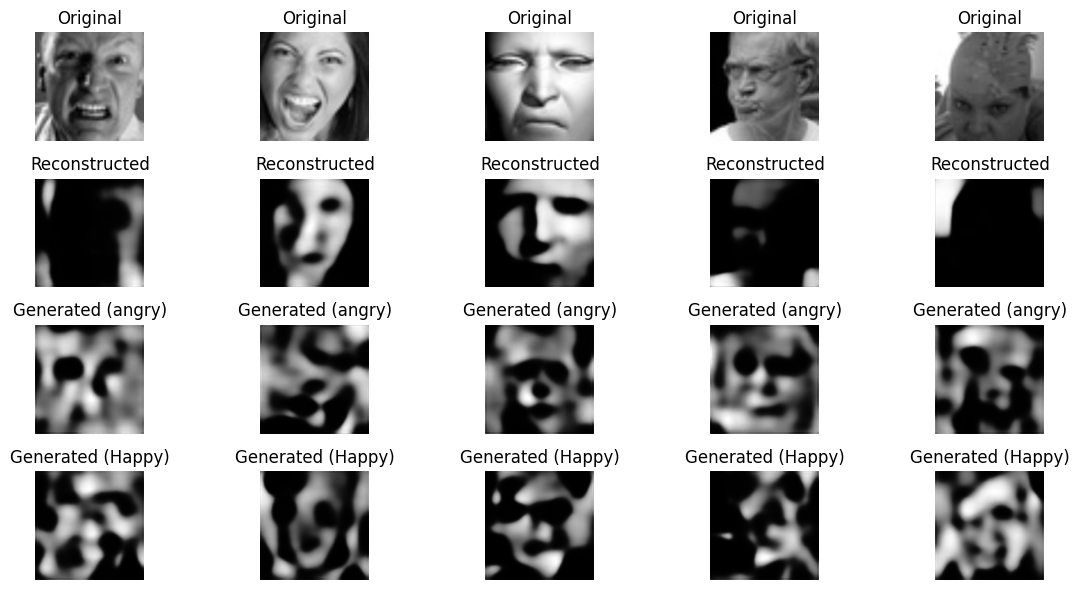

Epoch 6/30 (β=0.0167): 100%|██████████| 294/294 [03:51<00:00,  1.27it/s, Loss=1.66e+4, Recon=1.66e+4, KL=382, β=0.0167]


Epoch 6, Avg Train Loss: 16379.8285, β: 0.0167
Epoch: 6, Average Test Loss: 16337.0248


Epoch 7/30 (β=0.0200): 100%|██████████| 294/294 [03:51<00:00,  1.27it/s, Loss=1.61e+4, Recon=1.61e+4, KL=373, β=0.02]


Epoch 7, Avg Train Loss: 16363.1342, β: 0.0200
Epoch: 7, Average Test Loss: 16342.7096


Epoch 8/30 (β=0.0233): 100%|██████████| 294/294 [03:51<00:00,  1.27it/s, Loss=1.65e+4, Recon=1.65e+4, KL=365, β=0.0233]


Epoch 8, Avg Train Loss: 16345.3745, β: 0.0233
Epoch: 8, Average Test Loss: 16307.1708


Epoch 9/30 (β=0.0267): 100%|██████████| 294/294 [03:51<00:00,  1.27it/s, Loss=1.64e+4, Recon=1.64e+4, KL=356, β=0.0267]


Epoch 9, Avg Train Loss: 16332.2227, β: 0.0267
Epoch: 9, Average Test Loss: 16305.0786


Epoch 10/30 (β=0.0300): 100%|██████████| 294/294 [03:51<00:00,  1.27it/s, Loss=1.63e+4, Recon=1.62e+4, KL=346, β=0.03]


Epoch 10, Avg Train Loss: 16324.9218, β: 0.0300
Epoch: 10, Average Test Loss: 16298.6169


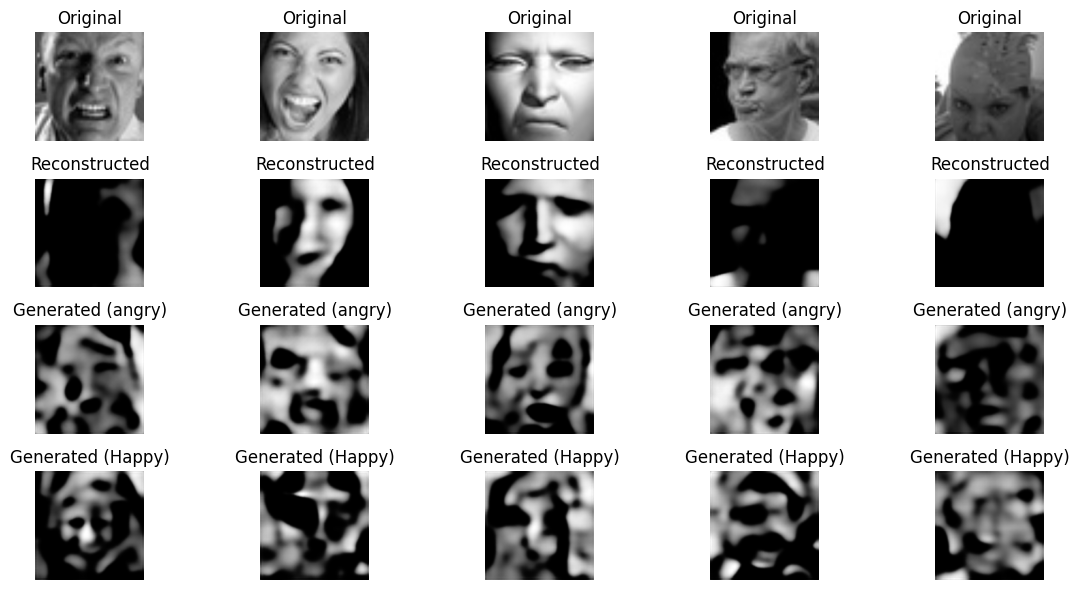

Epoch 11/30 (β=0.0333): 100%|██████████| 294/294 [03:51<00:00,  1.27it/s, Loss=1.62e+4, Recon=1.62e+4, KL=337, β=0.0333]


Epoch 11, Avg Train Loss: 16315.3023, β: 0.0333
Epoch: 11, Average Test Loss: 16299.9143


Epoch 12/30 (β=0.0367): 100%|██████████| 294/294 [03:51<00:00,  1.27it/s, Loss=1.64e+4, Recon=1.63e+4, KL=331, β=0.0367]


Epoch 12, Avg Train Loss: 16308.7970, β: 0.0367
Epoch: 12, Average Test Loss: 16296.4428


Epoch 13/30 (β=0.0400): 100%|██████████| 294/294 [03:51<00:00,  1.27it/s, Loss=1.63e+4, Recon=1.63e+4, KL=327, β=0.04]


Epoch 13, Avg Train Loss: 16302.2171, β: 0.0400
Epoch: 13, Average Test Loss: 16297.7497


Epoch 14/30 (β=0.0433): 100%|██████████| 294/294 [03:51<00:00,  1.27it/s, Loss=1.6e+4, Recon=1.6e+4, KL=323, β=0.0433]


Epoch 14, Avg Train Loss: 16299.0547, β: 0.0433
Epoch: 14, Average Test Loss: 16290.5032


Epoch 15/30 (β=0.0467): 100%|██████████| 294/294 [03:51<00:00,  1.27it/s, Loss=1.59e+4, Recon=1.59e+4, KL=318, β=0.0467]


Epoch 15, Avg Train Loss: 16291.9179, β: 0.0467
Epoch: 15, Average Test Loss: 16283.6612


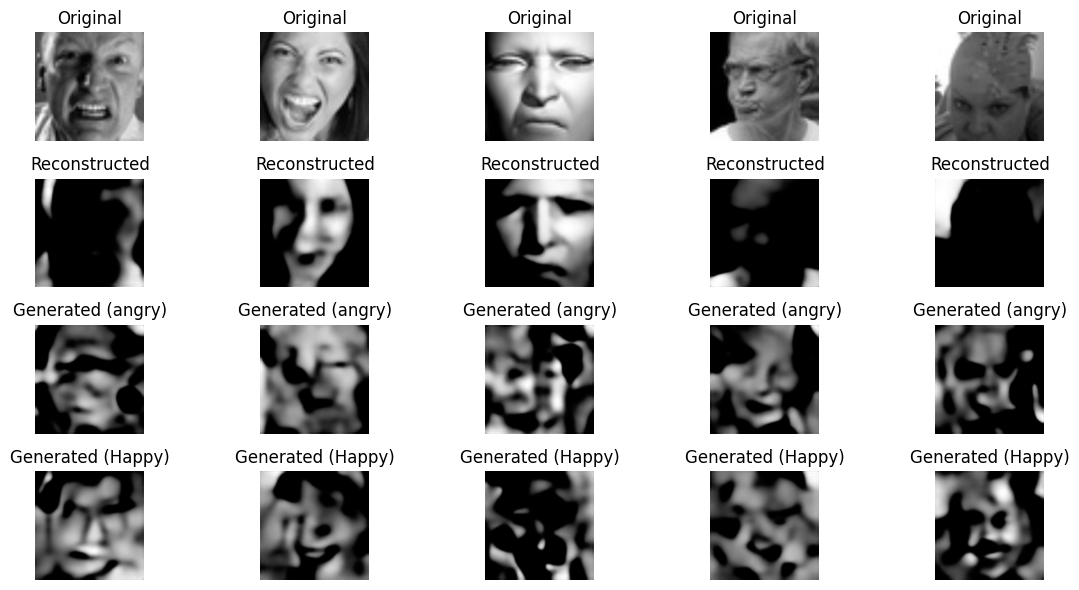

Epoch 16/30 (β=0.0500): 100%|██████████| 294/294 [03:51<00:00,  1.27it/s, Loss=1.63e+4, Recon=1.63e+4, KL=316, β=0.05]


Epoch 16, Avg Train Loss: 16288.0571, β: 0.0500
Epoch: 16, Average Test Loss: 16305.5491


Epoch 17/30 (β=0.0533): 100%|██████████| 294/294 [03:51<00:00,  1.27it/s, Loss=1.61e+4, Recon=1.61e+4, KL=309, β=0.0533]


Epoch 17, Avg Train Loss: 16285.1312, β: 0.0533
Epoch: 17, Average Test Loss: 16294.2661


Epoch 18/30 (β=0.0567): 100%|██████████| 294/294 [03:51<00:00,  1.27it/s, Loss=1.62e+4, Recon=1.62e+4, KL=306, β=0.0567]


Epoch 18, Avg Train Loss: 16281.6723, β: 0.0567
Epoch: 18, Average Test Loss: 16288.1163


Epoch 19/30 (β=0.0600): 100%|██████████| 294/294 [03:51<00:00,  1.27it/s, Loss=1.6e+4, Recon=1.6e+4, KL=302, β=0.06]


Epoch 19, Avg Train Loss: 16279.0098, β: 0.0600
Epoch: 19, Average Test Loss: 16283.1603


Epoch 20/30 (β=0.0633): 100%|██████████| 294/294 [03:51<00:00,  1.27it/s, Loss=1.64e+4, Recon=1.64e+4, KL=295, β=0.0633]


Epoch 20, Avg Train Loss: 16274.6365, β: 0.0633
Epoch: 20, Average Test Loss: 16285.6360


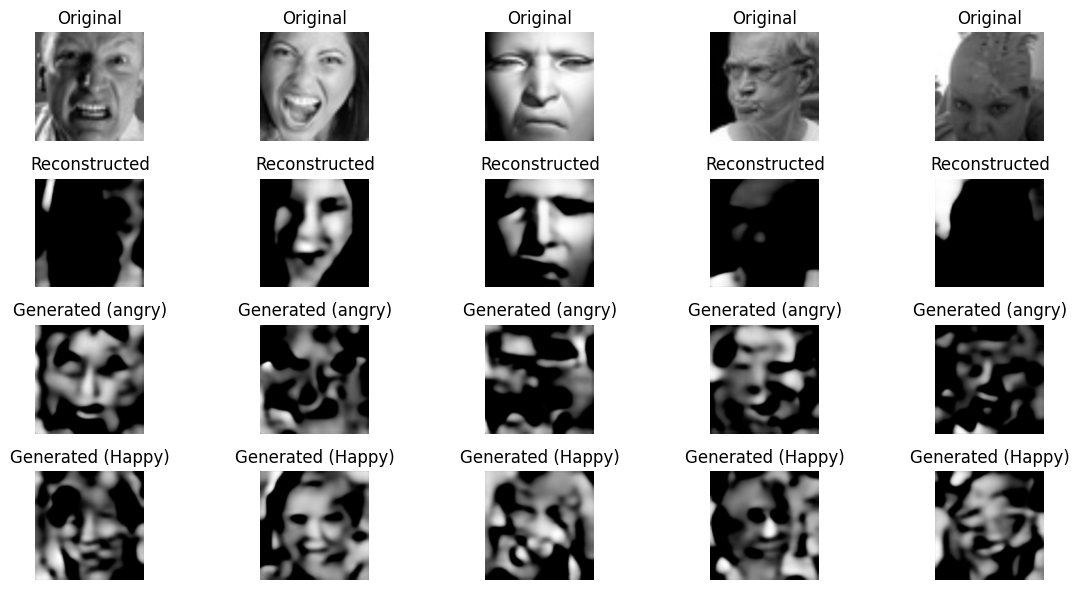

Epoch 21/30 (β=0.0667): 100%|██████████| 294/294 [03:51<00:00,  1.27it/s, Loss=1.65e+4, Recon=1.65e+4, KL=292, β=0.0667]


Epoch 21, Avg Train Loss: 16271.1873, β: 0.0667
Epoch: 21, Average Test Loss: 16281.2036


Epoch 22/30 (β=0.0700): 100%|██████████| 294/294 [03:51<00:00,  1.27it/s, Loss=1.62e+4, Recon=1.61e+4, KL=288, β=0.07]


Epoch 22, Avg Train Loss: 16269.5948, β: 0.0700
Epoch: 22, Average Test Loss: 16279.1043


Epoch 23/30 (β=0.0733): 100%|██████████| 294/294 [03:51<00:00,  1.27it/s, Loss=1.59e+4, Recon=1.59e+4, KL=293, β=0.0733]


Epoch 23, Avg Train Loss: 16267.9836, β: 0.0733
Epoch: 23, Average Test Loss: 16283.7442


Epoch 24/30 (β=0.0767): 100%|██████████| 294/294 [03:51<00:00,  1.27it/s, Loss=1.64e+4, Recon=1.64e+4, KL=277, β=0.0767]


Epoch 24, Avg Train Loss: 16264.5533, β: 0.0767
Epoch: 24, Average Test Loss: 16279.0111


Epoch 25/30 (β=0.0800): 100%|██████████| 294/294 [03:51<00:00,  1.27it/s, Loss=1.62e+4, Recon=1.62e+4, KL=282, β=0.08]


Epoch 25, Avg Train Loss: 16265.1991, β: 0.0800
Epoch: 25, Average Test Loss: 16280.7613


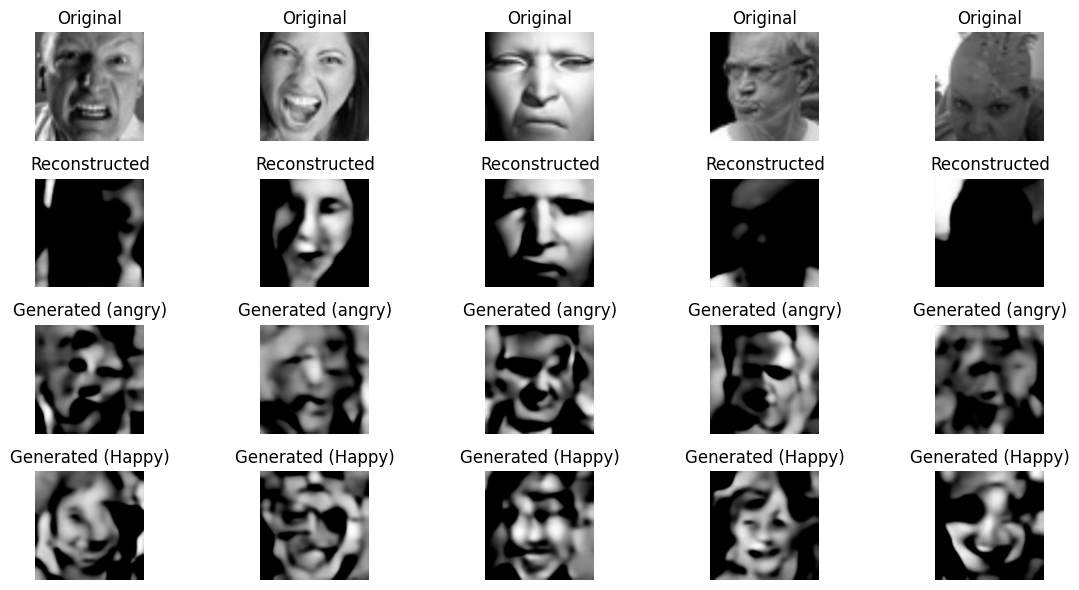

Epoch 26/30 (β=0.0833): 100%|██████████| 294/294 [03:51<00:00,  1.27it/s, Loss=1.64e+4, Recon=1.63e+4, KL=280, β=0.0833]


Epoch 26, Avg Train Loss: 16264.1883, β: 0.0833
Epoch: 26, Average Test Loss: 16283.6595


Epoch 27/30 (β=0.0867): 100%|██████████| 294/294 [03:51<00:00,  1.27it/s, Loss=1.6e+4, Recon=1.6e+4, KL=276, β=0.0867]


Epoch 27, Avg Train Loss: 16261.3018, β: 0.0867
Epoch: 27, Average Test Loss: 16279.4739


Epoch 28/30 (β=0.0900): 100%|██████████| 294/294 [03:51<00:00,  1.27it/s, Loss=1.65e+4, Recon=1.64e+4, KL=265, β=0.09]


Epoch 28, Avg Train Loss: 16259.9491, β: 0.0900
Epoch: 28, Average Test Loss: 16280.7727


Epoch 29/30 (β=0.0933): 100%|██████████| 294/294 [03:51<00:00,  1.27it/s, Loss=1.64e+4, Recon=1.64e+4, KL=267, β=0.0933]


Epoch 29, Avg Train Loss: 16259.3553, β: 0.0933
Epoch: 29, Average Test Loss: 16281.5132


Epoch 30/30 (β=0.0967): 100%|██████████| 294/294 [03:51<00:00,  1.27it/s, Loss=1.62e+4, Recon=1.62e+4, KL=265, β=0.0967]


Epoch 30, Avg Train Loss: 16257.9285, β: 0.0967
Epoch: 30, Average Test Loss: 16280.6558


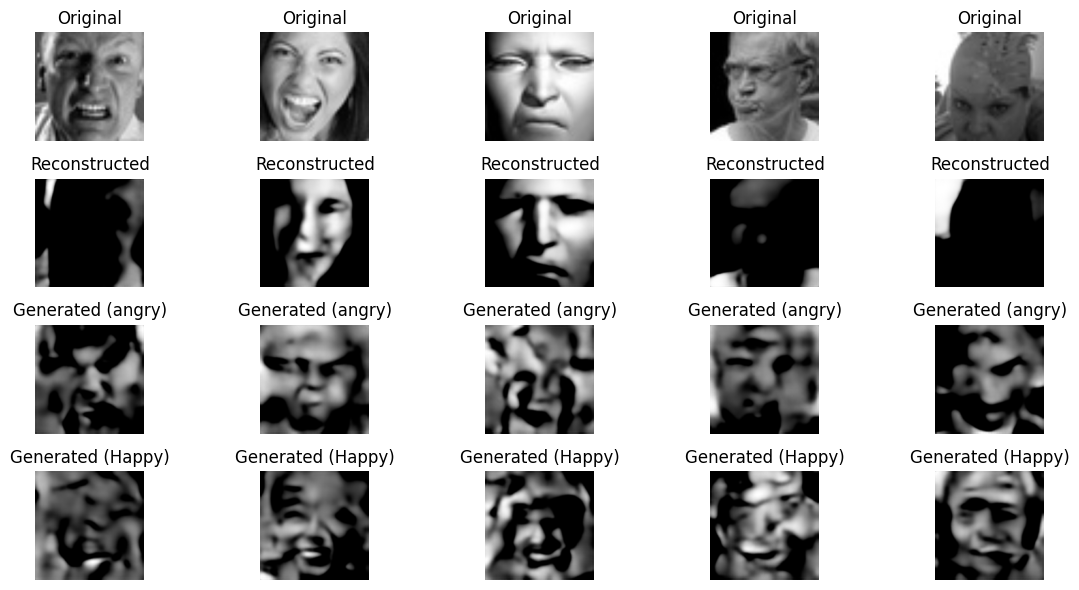

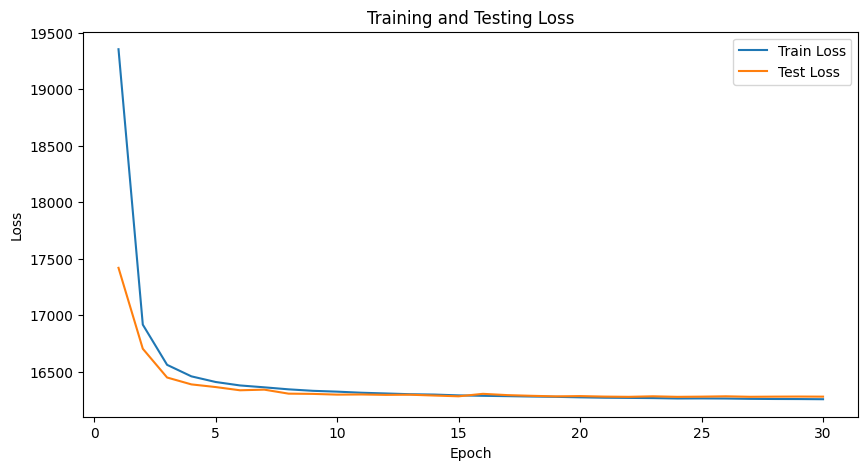

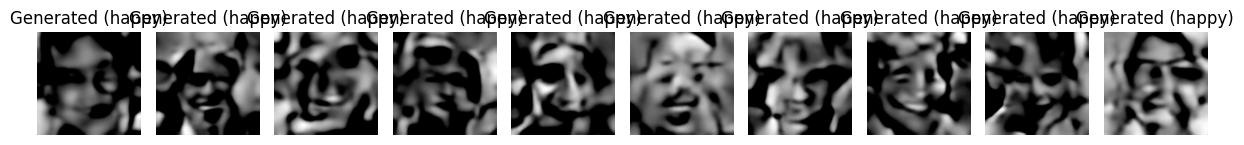

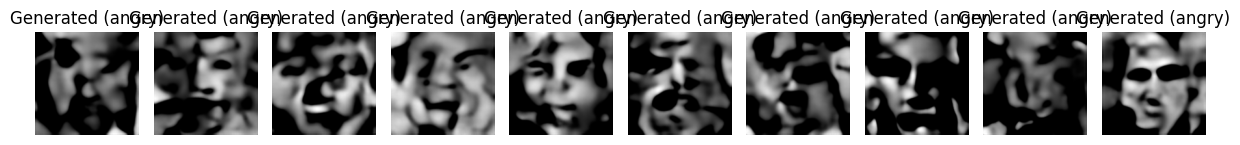

In [ ]:


# Main training loop
if __name__ == "__main__":
    train_losses = []
    test_losses = []

    for epoch in range(EPOCHS):
        train_loss = train(cvae, train_loader, optimizer, epoch)
        test_loss = test(cvae, test_loader, epoch)

        train_losses.append(train_loss)
        test_losses.append(test_loss)

        # Visualize results every 5 epochs
        if (epoch + 1) % 5 == 0:
            visualize_results(cvae, test_loader)

    # Save the trained model
    torch.save(cvae.state_dict(), 'cvae_emotion_face_model.pth')

    # Plot loss curves
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, EPOCHS + 1), train_losses, label='Train Loss')
    plt.plot(range(1, EPOCHS + 1), test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Testing Loss')
    plt.legend()
    plt.savefig('loss_curves.png')
    plt.show()

    # Function to generate faces with specific emotion
    def generate_faces(model, emotion="happy", num_samples=5):
        model.eval()

        # Create condition vector
        condition = torch.zeros(1, NUM_CONDITIONS).to(device)
        if emotion.lower() == "happy":
            condition[0, 1] = 1
        else:  # angry
            condition[0, 0] = 1

        # Generate images
        with torch.no_grad():
            generated = model.generate(condition, num_samples)

        # Visualize generated images
        plt.figure(figsize=(12, 3))
        for i in range(num_samples):
            plt.subplot(1, num_samples, i + 1)
            plt.imshow(generated[i].cpu().squeeze().numpy(), cmap='gray')
            plt.title(f"Generated ({emotion})")
            plt.axis('off')

        plt.tight_layout()
        plt.savefig(f'generated_{emotion}_faces.png')
        plt.show()

    # Generate 10 happy and 10 angry faces
    generate_faces(cvae, "happy", 10)
    generate_faces(cvae, "angry", 10)

In [ ]:
torch.save(cvae.state_dict(), '/content/drive/MyDrive/cvae_emotion_face_model.pth')

In [ ]:
cvae = ConditionalVAE().to(device)
cvae.load_state_dict(torch.load('cvae_emotion_face_model.pth', map_location=device))

<All keys matched successfully>

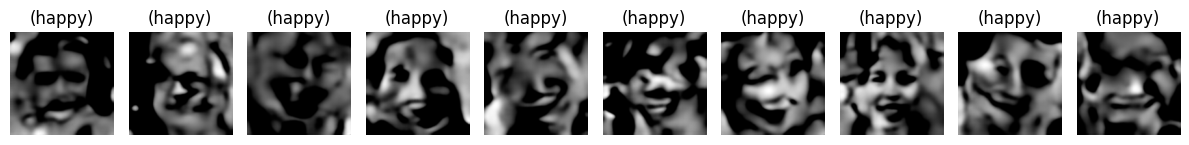

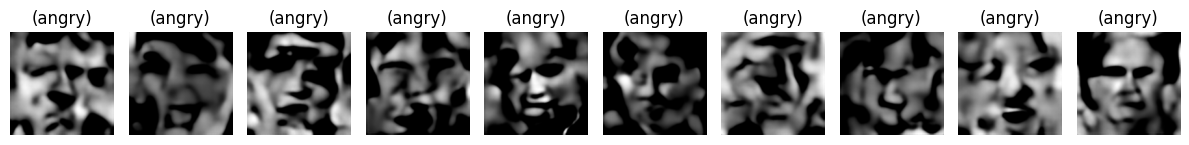

In [ ]:
import matplotlib.pyplot as plt

def generate_faces(model, emotion="happy", num_samples=5):
        model.eval()

        # Create condition vector
        condition = torch.zeros(1, NUM_CONDITIONS).to(device)
        if emotion.lower() == "happy":
            condition[0, 1] = 1
        else:  # angry
            condition[0, 0] = 1

        # Generate images
        with torch.no_grad():
            generated = model.generate(condition, num_samples)

        # Visualize generated images
        plt.figure(figsize=(12, 3))
        for i in range(num_samples):
            plt.subplot(1, num_samples, i + 1)
            plt.imshow(generated[i].cpu().squeeze().numpy(), cmap='gray')
            plt.title(f"({emotion})")
            plt.axis('off')

        plt.tight_layout()
        plt.savefig(f'generated_{emotion}_faces.png')
        plt.show()


generate_faces(cvae, "happy", 10)
generate_faces(cvae, "angry", 10)

In [ ]:
!pip install facenet-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 35.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 123.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 120.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.6/755.6 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 117.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 104.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 62.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 43.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
import time
from google.colab import runtime

# Your training code here
time.sleep(30)  # Simulate a 5-minute training process
print("Training finished!")

runtime.unassign()

Training finished!


In [ ]:
from facenet_pytorch import MTCNN
import torch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle

# Initialize MTCNN for face detection
mtcnn = MTCNN(keep_all=True)


def detect_generated_faces(model, emotion="happy", num_samples=5):
    model.eval()

    # Create condition vector
    condition = torch.zeros(1, NUM_CONDITIONS).to(device)
    if emotion.lower() == "happy":
        condition[0, 1] = 1
    else:  # angry
        condition[0, 0] = 1

    # Generate images
    with torch.no_grad():
        generated = model.generate(condition, num_samples)
    face_count = 0
    # Visualize generated images
    for i in range(num_samples):
        face_tensor = generated[i].cpu()  # shape: [1, H, W]
        pil_img = transforms.ToPILImage()(face_tensor.squeeze(0)).convert("RGB")
        #pil_img = pil_img.resize((40, 40), Image.BILINEAR)

        # Detect face
        boxes, probs = mtcnn.detect(pil_img)
        #print(f"Face {i+1} - Detected {len(boxes) if boxes is not None else 0} face(s)")

        # Visualize
        #img_array = np.array(pil_img)
        #plt.figure(figsize=(3, 3))
        #plt.imshow(img_array)
        #ax = plt.gca()

        if boxes is not None:
            face_count+=len(boxes)
            aligned = mtcnn(pil_img)
            # print(aligned.shape)

            for box, prob in zip(boxes, probs):
                x1, y1, x2, y2 = box
                rect = Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor='r', facecolor='none')

    print(f'Detected {face_count} faces for {emotion}!!!!!!!!!!!!!!!')


# Generate 10 happy and 10 angry faces
detect_generated_faces(cvae, "happy", 100)
detect_generated_faces(cvae, "angry", 100)

Detected 31 faces for happy!!!!!!!!!!!!!!!
Detected 41 faces for angry!!!!!!!!!!!!!!!


4


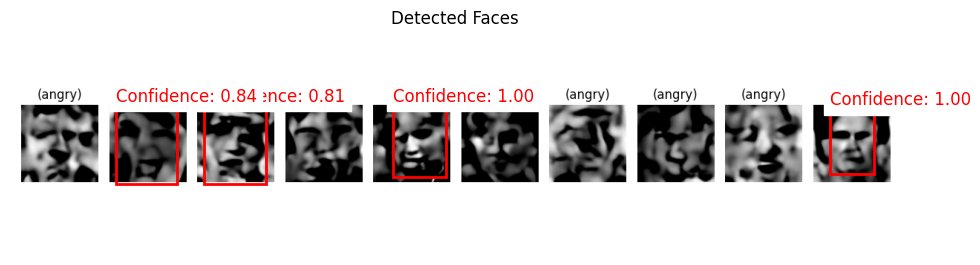

In [ ]:
from facenet_pytorch import MTCNN
import torch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle

# Initialize MTCNN for face detection
mtcnn = MTCNN(keep_all=True)

# Load pre-trained FaceNet model

# Load an image containing faces
img = Image.open('generated_angry_faces.png')

if img.mode == 'RGBA':
    img = img.convert('RGB')

# Detect faces in the image
boxes, probs = mtcnn.detect(img)
print(len(boxes))
# Convert image for plotting
img_array = np.array(img)

# Plot the original image with face detections
plt.figure(figsize=(10, 10))
plt.imshow(img_array)
ax = plt.gca()

# If faces are detected, extract embeddings and draw boxes
if boxes is not None:
    aligned = mtcnn(img)

    # Draw boxes for each detected face
    for box, prob in zip(boxes, probs):
        # Extract coordinates (x1, y1, x2, y2)
        x1, y1, x2, y2 = box

        # Create rectangle patch
        rect = Rectangle((x1, y1), x2-x1, y2-y1,
                         linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

        # Add confidence score text
        plt.text(x1, y1-10, f"Confidence: {prob:.2f}",
                 color='red', fontsize=12, backgroundcolor='white')

plt.title('Detected Faces')
plt.axis('off')
plt.tight_layout()
plt.show()

4


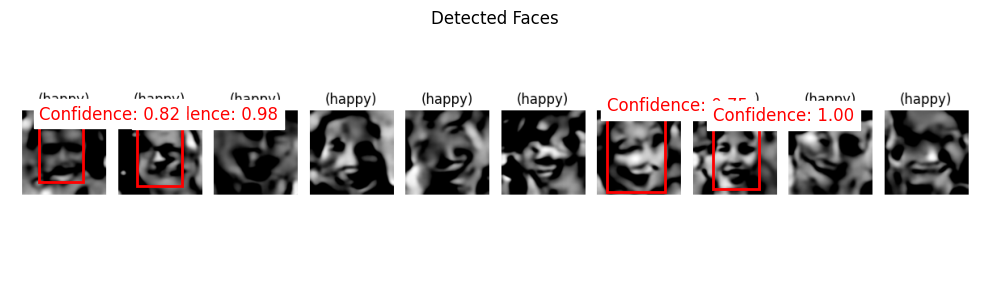

In [ ]:
from facenet_pytorch import MTCNN
import torch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle

# Initialize MTCNN for face detection
mtcnn = MTCNN(keep_all=True)

# Load pre-trained FaceNet model

# Load an image containing faces
img = Image.open('generated_happy_faces.png')

if img.mode == 'RGBA':
    img = img.convert('RGB')

# Detect faces in the image
boxes, probs = mtcnn.detect(img)
print(len(boxes))
# Convert image for plotting
img_array = np.array(img)

# Plot the original image with face detections
plt.figure(figsize=(10, 10))
plt.imshow(img_array)
ax = plt.gca()

# If faces are detected, extract embeddings and draw boxes
if boxes is not None:
    aligned = mtcnn(img)

    # Draw boxes for each detected face
    for box, prob in zip(boxes, probs):
        # Extract coordinates (x1, y1, x2, y2)
        x1, y1, x2, y2 = box

        # Create rectangle patch
        rect = Rectangle((x1, y1), x2-x1, y2-y1,
                         linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

        # Add confidence score text
        plt.text(x1, y1-10, f"Confidence: {prob:.2f}",
                 color='red', fontsize=12, backgroundcolor='white')

plt.title('Detected Faces')
plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.manifold import TSNE
from sklearn.metrics import pairwise_distances
import numpy as np
from facenet_pytorch import InceptionResnetV1

resnet = InceptionResnetV1(pretrained='casia-webface').eval()

def detect_emotion_distance(model, num_samples=50):
    model.eval()
    all_embeddings = []
    all_labels = []

    def generate_embeddings(emotion_label):
        condition = torch.zeros(1, NUM_CONDITIONS).to(device)
        condition[0, 1] = 1 if emotion_label == 'happy' else 0
        condition[0, 0] = 1 if emotion_label == 'angry' else 0

        with torch.no_grad():
            generated = model.generate(condition, num_samples)

        embeddings = []
        for i in range(num_samples):
            face_tensor = generated[i].cpu()
            pil_img = transforms.ToPILImage()(face_tensor.squeeze(0)).convert("RGB")
            boxes, _ = mtcnn.detect(pil_img)

            aligned = mtcnn(pil_img)

            if aligned is not None:
                print(aligned.shape)
                with torch.no_grad():
                    emb = resnet(aligned).detach().cpu().numpy()
                embeddings.append(emb[0])  # extract vector

        return embeddings

    # Generate and collect embeddings
    happy_embeds = generate_embeddings('happy')
    angry_embeds = generate_embeddings('angry')

    all_embeddings = np.array(happy_embeds + angry_embeds)
    all_labels = np.array([1] * len(happy_embeds) + [0] * len(angry_embeds))

    # Apply t-SNE
    tsne = tsne = TSNE(n_components=2,perplexity=5, random_state=42)
    reduced = tsne.fit_transform(all_embeddings)

    # Compute class means
    happy_points = reduced[all_labels == 1]
    angry_points = reduced[all_labels == 0]

    happy_centroid = np.mean(happy_points, axis=0)
    angry_centroid = np.mean(angry_points, axis=0)

    # Compute distances
    intra_happy = np.mean(pairwise_distances(happy_points, [happy_centroid]))
    intra_angry = np.mean(pairwise_distances(angry_points, [angry_centroid]))
    inter_class = np.linalg.norm(happy_centroid - angry_centroid)

    print(f"Happy Intra-class Distance: {intra_happy:.4f}")
    print(f"Angry Intra-class Distance: {intra_angry:.4f}")
    print(f"Inter-class Distance: {inter_class:.4f}")

    # Plot
    plt.figure(figsize=(6, 5))
    plt.scatter(happy_points[:, 0], happy_points[:, 1], label='Happy', c='blue', alpha=0.6)
    plt.scatter(angry_points[:, 0], angry_points[:, 1], label='Angry', c='red', alpha=0.6)
    plt.scatter(*happy_centroid, color='blue', marker='x', s=100, label='Happy Centroid')
    plt.scatter(*angry_centroid, color='red', marker='x', s=100, label='Angry Centroid')
    plt.legend()
    plt.title("t-SNE Visualization of Emotion Embeddings")
    plt.tight_layout()
    plt.show()


ModuleNotFoundError: No module named 'numpy.strings'

In [ ]:
detect_emotion_distance(cvae)

NameError: name 'detect_emotion_distance' is not defined